load data...
training regressor...
score= -2.1635487444419765
plotting feature importance...
(tonal.hpcp.mean,)                                   0.047102
(lowlevel.silence_rate_20dB.dvar2,)                  0.046195
(lowlevel.silence_rate_20dB.mean,)                   0.037347
(lowlevel.melbands_kurtosis.var,)                    0.037167
(lowlevel.erbbands_kurtosis.median,)                 0.027563
(lowlevel.pitch_salience.min,)                       0.025840
(lowlevel.pitch_salience.mean,)                      0.024844
(lowlevel.spectral_energy.dmean,)                    0.024096
(lowlevel.melbands_kurtosis.stdev,)                  0.021438
(tonal.hpcp_entropy.median,)                         0.020341
(lowlevel.erbbands_kurtosis.mean,)                   0.019323
(tonal.hpcp_crest.max,)                              0.019259
(lowlevel.spectral_energyband_middle_high.mean,)     0.019069
(lowlevel.spectral_energy.dmean2,)                   0.018771
(lowlevel.silence_rate_20dB.var,)      

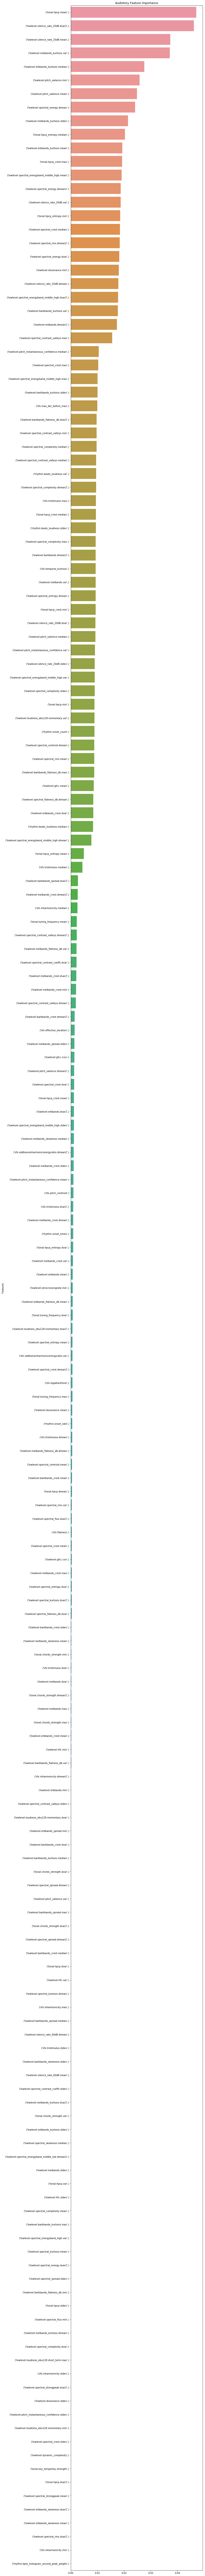

In [2]:
import pickle as pkl
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

print('load data...')
data = pkl.load(open("/Users/simonzimmermann/dev/random_forest_regressor/test_files_features.pkl", "rb"))
target_index = len(data.iloc[0]) - 1
x_input = data.iloc[:, : target_index - 1]
x_input = x_input.fillna(0)
target = pkl.load(open("/Users/simonzimmermann/dev/random_forest_regressor/datasets/pkl/brunnensounds_mean.pkl"))

x_train, x_test, y_train, y_test = train_test_split(x_input, target, test_size=0.3)

print('training regressor...')
regressor = RandomForestRegressor(n_estimators=100, max_depth=2, random_state=0)
regressor.fit(x_train, y_train)
y_pred = regressor.predict(x_test)
print("score= " + str(regressor.score(x_test, y_test)))

print('plotting feature importance...')
feature_imp = pd.Series(regressor.feature_importances_, index=x_input.columns).sort_values(ascending=False)
feature_imp = feature_imp[feature_imp > 0]  
print(feature_imp)

a4_dims = (10, 200)
fig, ax = plt.subplots(figsize=a4_dims)
sns.barplot(ax=ax, x=feature_imp, y=feature_imp.index)
plt.title("Feature Importance Score")
plt.ylabel('Features')
plt.title("Audiotory Feature Importance")
plt.legend()


(lowlevel.barkbands_kurtosis.dmean,)                 0.053984
(sfx.max_der_before_max,)                            0.045714
(lowlevel.spectral_rms.dmean2,)                      0.044570
(lowlevel.pitch_salience.mean,)                      0.043407
(lowlevel.spectral_energyband_middle_high.mean,)     0.042470
(lowlevel.erbbands_kurtosis.median,)                 0.035701
(lowlevel.barkbands_kurtosis.mean,)                  0.018846
(rhythm.beats_loudness.var,)                         0.018682
(lowlevel.spectral_complexity.mean,)                 0.018645
(lowlevel.barkbands_crest.median,)                   0.018579
(lowlevel.barkbands.dmean2,)                         0.018383
(lowlevel.silence_rate_20dB.stdev,)                  0.018185
(lowlevel.spectral_energyband_middle_high.dvar,)     0.018175
(lowlevel.erbbands_spread.dvar2,)                    0.018156
(lowlevel.spectral_energyband_middle_high.dmean,)    0.017646
(lowlevel.spectral_rms.dmean,)                       0.015818
(lowleve

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174]),)

647